# Organizando os dados

In [93]:
import os
import shutil
import random

In [94]:
#remove todos as imagens que tem no final _inverted.png
for root, dirs, files in os.walk("data"):
    for file in files:
        if file.endswith("_inverted.png"):
            os.remove(os.path.join(root, file))
    

In [95]:
def reorganize_dataset(source_dir, dest_dir):
    # Criar as pastas de destino
    for split in ['treino', 'teste', 'validacao']:
        os.makedirs(os.path.join(dest_dir, split), exist_ok=True)

    # Iterar sobre as pastas de personagens
    for character in os.listdir(source_dir):
        character_dir = os.path.join(source_dir, character)
        if os.path.isdir(character_dir):
            # Listar todas as imagens do personagem
            images = [img for img in os.listdir(character_dir) if img.lower().endswith(('.png', '.jpg', '.jpeg', '.gif'))]
            random.shuffle(images)

            # Calcular o número de imagens para cada split
            total_images = len(images)
            train_count = int(total_images * 0.8)
            test_count = int(total_images * 0.1)

            # Dividir as imagens
            train_images = images[:train_count]
            test_images = images[train_count:train_count + test_count]
            val_images = images[train_count + test_count:]

            # Copiar as imagens para os respectivos diretórios
            for split, img_list in [('treino', train_images), ('teste', test_images), ('validacao', val_images)]:
                split_char_dir = os.path.join(dest_dir, split, character)
                os.makedirs(split_char_dir, exist_ok=True)
                for img in img_list:
                    src = os.path.join(character_dir, img)
                    dst = os.path.join(split_char_dir, img)
                    shutil.copy2(src, dst)

    print("Reorganização concluída!")


In [96]:
# Diretórios de origem e destino
source_directory = 'data'
destination_directory = 'data_reorganized'

# Executar a reorganização
reorganize_dataset(source_directory, destination_directory)

Reorganização concluída!


# Importações Necessárias

In [1]:
import numpy as np
import PIL.Image
from PIL import Image
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report

import torch, torchvision
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.optim as optim
import time
from matplotlib import pyplot as plt

import os

# Pré-processamento e definição de variáveis

In [2]:
image_size = 256

transformacoes_de_imagens = { 
    'treino': transforms.Compose([
        transforms.Resize(size=[image_size, image_size]),
        transforms.ToTensor(),
    ]),
    'validacao': transforms.Compose([
        transforms.Resize(size=[image_size, image_size]),
        transforms.ToTensor(),
    ]),
    'teste': transforms.Compose([
        transforms.Resize(size=[image_size, image_size]),
        transforms.ToTensor(),
    ])
}

In [3]:
dataset = r'./data_reorganized/'

pasta_treino = os.path.join(dataset, 'treino')
pasta_validacao = os.path.join(dataset, 'validacao')
pasta_teste = os.path.join(dataset, 'teste')

In [4]:
# BathSize
bs = 300

numero_de_classes = len(os.listdir(pasta_teste)) 
numero_de_classes

18

In [5]:
data = {
    'treino': datasets.ImageFolder(root=pasta_treino, transform=transformacoes_de_imagens['treino']),
    'validacao': datasets.ImageFolder(root=pasta_validacao, transform=transformacoes_de_imagens['validacao'])
}

In [6]:
data

{'treino': Dataset ImageFolder
     Number of datapoints: 6767
     Root location: ./data_reorganized/treino
     StandardTransform
 Transform: Compose(
                Resize(size=[256, 256], interpolation=bilinear, max_size=None, antialias=True)
                ToTensor()
            ),
 'validacao': Dataset ImageFolder
     Number of datapoints: 860
     Root location: ./data_reorganized/validacao
     StandardTransform
 Transform: Compose(
                Resize(size=[256, 256], interpolation=bilinear, max_size=None, antialias=True)
                ToTensor()
            )}

In [7]:
# Mapear os índices com os nomes das classes
indice_para_classe = {v: k for k, v in data['treino'].class_to_idx.items()}
print(indice_para_classe)

# Quantidade de imagens para serem utilizados para calcular erro e acurácia
num_imagens_treino = len(data['treino'])
num_imagens_validacao = len(data['validacao'])

# Cria os DataLoaders para treino e validação
data_loader_treino = DataLoader(data['treino'], batch_size=bs, shuffle=True, num_workers=4)
data_loader_validacao = DataLoader(data['validacao'], batch_size=bs, shuffle=True, num_workers=4)

{0: 'Ace', 1: 'Akainu', 2: 'Brook', 3: 'Chopper', 4: 'Crocodile', 5: 'Franky', 6: 'Jinbei', 7: 'Kurohige', 8: 'Law', 9: 'Luffy', 10: 'Mihawk', 11: 'Nami', 12: 'Rayleigh', 13: 'Robin', 14: 'Sanji', 15: 'Shanks', 16: 'Usopp', 17: 'Zoro'}


# MobileNetV2

In [9]:
MobileNetV2 = models.mobilenet_v2(pretrained=True)
MobileNetV2

c:\Users\ander\anaconda3\envs\py38\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\ander\anaconda3\envs\py38\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


MobileNetV2(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(96, eps=

## Transfer Learning

In [10]:
# Congelar os parametros da rede pré-treinada   
for param in MobileNetV2.parameters():
    param.requires_grad = False

In [11]:
# Mudar a última camada para alterar o número de classes
MobileNetV2.classifier[1] = nn.Linear(1280, numero_de_classes)
MobileNetV2.classifier.add_module("2", nn.LogSoftmax(dim = 1))
MobileNetV2

MobileNetV2(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(96, eps=

## Treinamento e Validação

In [12]:
# Algoritmo de otimização e função de erro
funcao_erro = nn.NLLLoss() # negative log likelihood loss
otimizador = optim.Adam(MobileNetV2.parameters()) # otimizador Adam
otimizador

Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.001
    maximize: False
    weight_decay: 0
)

In [13]:
def treinar_e_validar(modelo, metrica_erro, otimizador_sgd, epocas=20):
    historico = []
    melhor_acuracia = 0.0
    melhor_modelo = None

    modelo = modelo.to(device) # Joga para a GPU

    # Calcula erros de treino e validação para cada época
    for epoca in range(epocas):
        inicio_epoca = time.time()
        print("\n\nÉpoca: {}/{}".format(epoca+1, epocas))
        
        # Permite que os pesos sejam atualizados
        modelo.train()
        
        erro_treino = 0.0
        acuracia_treino = 0.0
        erro_validacao = 0.0
        acuracia_validacao = 0.0
        
        for i, (entradas, labels) in enumerate(data_loader_treino):
            entradas = entradas.to(device)
            labels = labels.to(device)
            
            # Limpa os gradientes
            otimizador_sgd.zero_grad()
            
            #Calcular as saídas a partir das entradas utilizando o modelo
            saidas = modelo(entradas)
            
            # comparando as classificacoes preditas com as reais
            erro = metrica_erro(saidas, labels)
            
            #backpropagation
            erro.backward()
            
            # Atualizar os parâmetros do otimizador
            otimizador_sgd.step()
            
            # Erro do lote
            erro_treino += erro.item() * entradas.size(0)
            
            # Cálculo da acurácia
            valores_maximos, indices_dos_valores_maximos = torch.max(saidas.data, 1)
            predicoes_corretas = indices_dos_valores_maximos.eq(labels.data.view_as(indices_dos_valores_maximos))
            acuracia = torch.mean(predicoes_corretas.type(torch.FloatTensor))
            acuracia_treino += acuracia.item() * entradas.size(0)
            
            print("Treino - Lote número {:03d}, Erro: {:.4f}, Acurácia: {:.4f}".format(i, erro.item(), acuracia.item()))

            
        # Validando com conjunto de validação
        with torch.no_grad():

            # Mudando de treino para avaliação
            modelo.eval()

            for j, (entradas, labels) in enumerate(data_loader_validacao):
                entradas = entradas.to(device)
                labels = labels.to(device)

                saidas = modelo(entradas)
                erro = metrica_erro(saidas, labels)

                erro_validacao += erro.item() * entradas.size(0)
                valores_maximos, indices_dos_valores_maximos = torch.max(saidas.data, 1)
                predicoes_corretas = indices_dos_valores_maximos.eq(labels.data.view_as(indices_dos_valores_maximos))
                acuracia = torch.mean(predicoes_corretas.type(torch.FloatTensor))
                acuracia_validacao += acuracia.item() * entradas.size(0)

                print("Validação - Lote número: {:03d}, Erro: {:.4f}, Acurácia: {:.4f}".format(j, erro.item(), acuracia.item()))
            
        # Calcular o erro e acurácia no treino
        erro_medio_treino = erro_treino/num_imagens_treino
        acuracia_media_treino = acuracia_treino/num_imagens_treino
        erro_medio_validacao = erro_validacao/num_imagens_validacao
        acuracia_media_validacao = acuracia_validacao/num_imagens_validacao

        # Append no histórico
        historico.append([erro_medio_treino, erro_medio_validacao, acuracia_media_treino, acuracia_media_validacao])
                
        fim_epoca = time.time()
    
        print("Época : {:03d}, Treino: Erro: {:.4f}, Acurácia: {:.4f}%, \n\t\tValidação : Erro : {:.4f}, Acurácia: {:.4f}%, Tempo: {:.4f}s".format(epoca+1, erro_medio_treino, acuracia_media_treino*100, erro_medio_validacao, acuracia_media_validacao*100, fim_epoca-inicio_epoca))
        
        # Salva o melhor modelo
        if acuracia_media_validacao > melhor_acuracia:
            melhor_acuracia = acuracia_media_validacao
            torch.save(modelo, './modelos/melhor_modelo.pt')
            melhor_modelo = modelo
            
    return melhor_modelo, historico

In [14]:

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f'{device}\n')
numero_de_epocas = 100
modelo_treinado, historico = treinar_e_validar(MobileNetV2, funcao_erro, otimizador, numero_de_epocas)



cuda:0



Época: 1/100
Treino - Lote número 000, Erro: 2.9678, Acurácia: 0.0733
Treino - Lote número 001, Erro: 2.8874, Acurácia: 0.0867
Treino - Lote número 002, Erro: 2.8926, Acurácia: 0.0767
Treino - Lote número 003, Erro: 2.7895, Acurácia: 0.1067
Treino - Lote número 004, Erro: 2.6879, Acurácia: 0.1433
Treino - Lote número 005, Erro: 2.6362, Acurácia: 0.1833
Treino - Lote número 006, Erro: 2.6086, Acurácia: 0.2300
Treino - Lote número 007, Erro: 2.5633, Acurácia: 0.2300
Treino - Lote número 008, Erro: 2.4886, Acurácia: 0.3300
Treino - Lote número 009, Erro: 2.4344, Acurácia: 0.3867
Treino - Lote número 010, Erro: 2.3425, Acurácia: 0.4033
Treino - Lote número 011, Erro: 2.2713, Acurácia: 0.4500
Treino - Lote número 012, Erro: 2.3163, Acurácia: 0.4100
Treino - Lote número 013, Erro: 2.2858, Acurácia: 0.4067
Treino - Lote número 014, Erro: 2.1889, Acurácia: 0.5033
Treino - Lote número 015, Erro: 2.0787, Acurácia: 0.5433
Treino - Lote número 016, Erro: 2.1757, Acurácia: 0.4667
Treino -

In [15]:
historico

[[2.3810797681374405,
  1.885408734166345,
  0.3570267506658335,
  0.5744186071462409],
 [1.5749016097893087,
  1.3380097566648972,
  0.6576030669491383,
  0.70813953460649],
 [1.2123573356282857,
  1.0965930112572604,
  0.7283877603444353,
  0.7441860589870187],
 [1.0325362619100125,
  0.9553258474483046,
  0.7541007845074453,
  0.766279069490211],
 [0.9090837155749109,
  0.8673934728600258,
  0.7777449362771592,
  0.7872093001077342],
 [0.8230043237805102,
  0.8068061637323957,
  0.7910447758287346,
  0.8011627848758254],
 [0.7612676459118378,
  0.7532100192336149,
  0.8169055722199146,
  0.8186046384101691],
 [0.7198686447174559,
  0.7167722499647806,
  0.8211910728867797,
  0.8290697585704715],
 [0.6747833800241868,
  0.6845562347145968,
  0.830205409939398,
  0.8220930210379667],
 [0.6416806288672389,
  0.6627257701962493,
  0.8358208983674155,
  0.8418604551359664],
 [0.6169322183270636,
  0.6437565296195275,
  0.844244124936233,
  0.8337209127670111],
 [0.5908624887272652,
  0.6

## Erro do melhor cenário

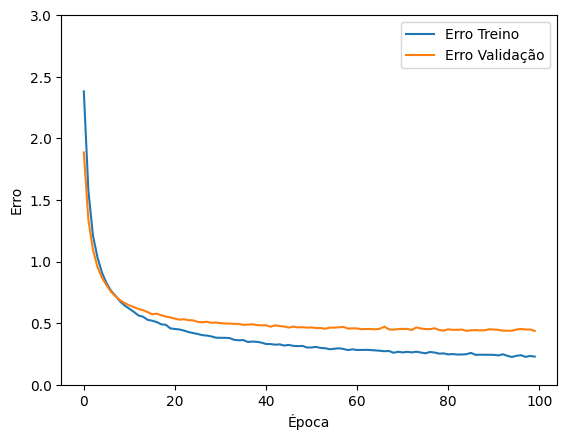

In [17]:
# Mostra o erro de treino e validação a cada época treinada

historico = np.array(historico)

plt.plot(historico[:,0:2])
plt.legend(['Erro Treino', 'Erro Validação'])
plt.xlabel('Época')
plt.ylabel('Erro')
plt.ylim(0,3)
plt.show()

### Comparação com outros testes feitos

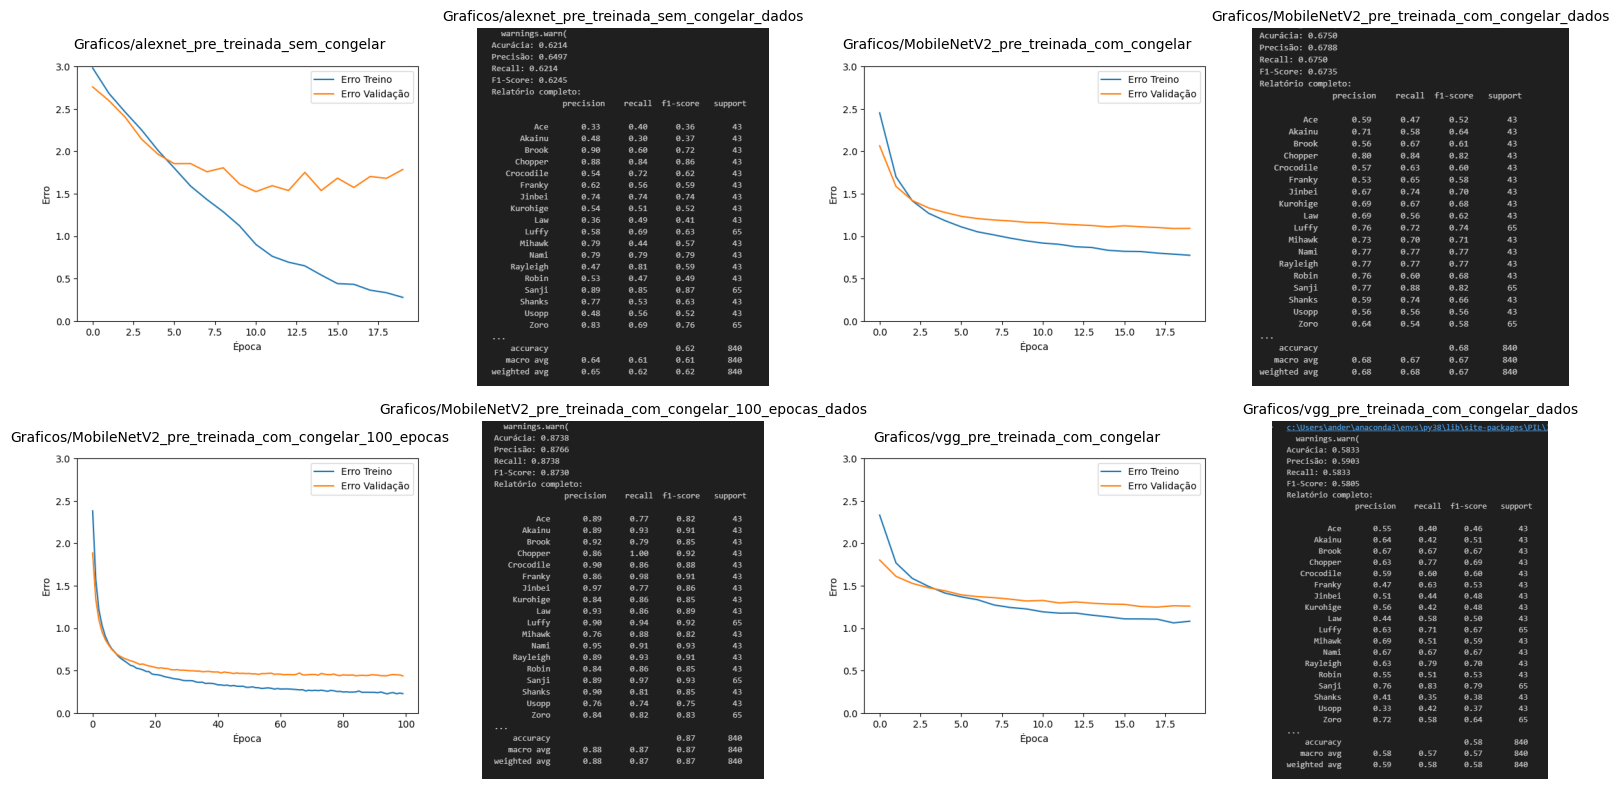

In [41]:
imagens = [
    "Graficos/alexnet_pre_treinada_sem_congelar.png",
    "Graficos/alexnet_pre_treinada_sem_congelar_dados.png",
    "Graficos/MobileNetV2_pre_treinada_com_congelar.png",
    "Graficos/MobileNetV2_pre_treinada_com_congelar_dados.png",
    "Graficos/MobileNetV2_pre_treinada_com_congelar_100_epocas.png",
    "Graficos/MobileNetV2_pre_treinada_com_congelar_100_epocas_dados.png",
    "Graficos/vgg_pre_treinada_com_congelar.png",
    "Graficos/vgg_pre_treinada_com_congelar_dados.png"
]

# Configura o layout do plot
fig, axes = plt.subplots(2, 4, figsize=(16, 8))

# Adiciona as imagens aos subplots
for i, ax in enumerate(axes.flat):
    img = Image.open(imagens[i])  # Abre a imagem
    ax.imshow(img)  # Exibe a imagem no subplot
    ax.axis('off')  # Remove os eixos
    ax.set_title(imagens[i].split(".")[0], fontsize=10)  # Título com o nome da imagem sem extensão

# Ajusta o espaçamento entre os subplots
plt.tight_layout()
plt.show()

## Função de predição

In [8]:
def predicao_one_piece(modelo, arquivo_imagem_teste):
    
    transformacao = transformacoes_de_imagens['teste']

    imagem_teste = PIL.Image.open(arquivo_imagem_teste)
    
    # Converta a imagem para RGB se tiver mais de 3 canais
    if imagem_teste.mode != 'RGB':
        imagem_teste = imagem_teste.convert('RGB')
    
    tensor_imagem_teste = transformacao(imagem_teste)

    tensor_imagem_teste = tensor_imagem_teste.unsqueeze(0)  #dimensão do batch

    if torch.cuda.is_available():
        tensor_imagem_teste = tensor_imagem_teste.cuda()
    
    dict_predicoes = dict()
    
    with torch.no_grad():
        modelo.eval()
        saida = modelo(tensor_imagem_teste)
        # torch.exp para voltar a probabilidade de log para a probabilidade linear
        ps = torch.exp(saida)
        
        # topk retorna os k maiores valores do tensor
        topk, topclass = ps.topk(numero_de_classes, dim=1)
        for i in range(numero_de_classes):
            dict_predicoes[indice_para_classe[topclass.cpu().numpy()[0][i]]] = topk.cpu().numpy()[0][i]
    
    return dict_predicoes

In [13]:
classe = 'Ace'
pasta = f'./data_reorganized/teste/{classe}/'
imagem = os.path.join(pasta, os.listdir(pasta)[12])

predicao_one_piece(modelo_treinado, imagem)

{'Ace': 0.8176811,
 'Luffy': 0.16638064,
 'Kurohige': 0.011544447,
 'Law': 0.004114979,
 'Chopper': 0.00010432502,
 'Mihawk': 7.8048404e-05,
 'Shanks': 3.6469155e-05,
 'Robin': 1.7586239e-05,
 'Franky': 1.4654557e-05,
 'Zoro': 9.453874e-06,
 'Usopp': 7.3701935e-06,
 'Akainu': 3.4355971e-06,
 'Jinbei': 2.9612888e-06,
 'Brook': 2.1290016e-06,
 'Sanji': 1.3041524e-06,
 'Crocodile': 1.0104617e-06,
 'Rayleigh': 4.041484e-08,
 'Nami': 3.0727403e-08}

## Avaliando no conjunto de teste

In [20]:
def avaliar_modelo(modelo, pasta_teste, indice_para_classe, transformacao):

    verdadeiros = []
    preditos = []

    # Itera por todas as subpastas (cada subpasta representa uma classe)
    for classe in os.listdir(pasta_teste):
        caminho_classe = os.path.join(pasta_teste, classe)
        
        if not os.path.isdir(caminho_classe):
            continue  # Ignora arquivos que não sejam pastas
        
        # Itera por todas as imagens na subpasta
        for imagem_nome in os.listdir(caminho_classe):
            caminho_imagem = os.path.join(caminho_classe, imagem_nome)
            imagem_teste = Image.open(caminho_imagem)
            
            # Converte a imagem para RGB se necessário
            if imagem_teste.mode != 'RGB':
                imagem_teste = imagem_teste.convert('RGB')
                
            # Aplica as transformações na imagem
            tensor_imagem_teste = transformacao(imagem_teste).unsqueeze(0)  # Adiciona a dimensão do batch
            
            if torch.cuda.is_available():
                tensor_imagem_teste = tensor_imagem_teste.cuda()
            
            # Realiza a predição
            with torch.no_grad():
                modelo.eval()
                saida = modelo(tensor_imagem_teste)
                ps = torch.exp(saida)
                topk, topclass = ps.topk(1, dim=1)  # Obtém a classe com a maior probabilidade
            
            # Rótulo previsto
            classe_prevista = indice_para_classe[topclass.cpu().numpy()[0][0]]
            preditos.append(classe_prevista)
            
            # Rótulo verdadeiro
            verdadeiros.append(classe)
    
    # Calcula as métricas usando sklearn
    acuracia = accuracy_score(verdadeiros, preditos)
    precisao = precision_score(verdadeiros, preditos, average='weighted')
    recall = recall_score(verdadeiros, preditos, average='weighted')
    f1 = f1_score(verdadeiros, preditos, average='weighted')
    
    # Gera o relatório de classificação completo
    relatorio = classification_report(verdadeiros, preditos, target_names=indice_para_classe.values())

    return acuracia, precisao, recall, f1, relatorio

In [21]:
pasta_teste = './data_reorganized/teste/'
acuracia, precisao, recall, f1, relatorio = avaliar_modelo(modelo_treinado, pasta_teste, indice_para_classe, transformacoes_de_imagens['teste'])

print(f"Acurácia: {acuracia:.4f}")
print(f"Precisão: {precisao:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")
print("Relatório completo:\n", relatorio)

c:\Users\ander\anaconda3\envs\py38\lib\site-packages\PIL\Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Acurácia: 0.8738
Precisão: 0.8766
Recall: 0.8738
F1-Score: 0.8730
Relatório completo:
               precision    recall  f1-score   support

         Ace       0.89      0.77      0.82        43
      Akainu       0.89      0.93      0.91        43
       Brook       0.92      0.79      0.85        43
     Chopper       0.86      1.00      0.92        43
   Crocodile       0.90      0.86      0.88        43
      Franky       0.86      0.98      0.91        43
      Jinbei       0.97      0.77      0.86        43
    Kurohige       0.84      0.86      0.85        43
         Law       0.93      0.86      0.89        43
       Luffy       0.90      0.94      0.92        65
      Mihawk       0.76      0.88      0.82        43
        Nami       0.95      0.91      0.93        43
    Rayleigh       0.89      0.93      0.91        43
       Robin       0.84      0.86      0.85        43
       Sanji       0.89      0.97      0.93        65
      Shanks       0.90      0.81      0.85     

In [22]:
#Salva o modelo 
torch.save(modelo_treinado, './modelos/modelo_final.pt')

# Exemplos de uso do melhor modelo

In [11]:
# importa o modelo
modelo_final = torch.load('./modelos/modelo_final.pt')
modelo_final.eval()

MobileNetV2(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(96, eps=

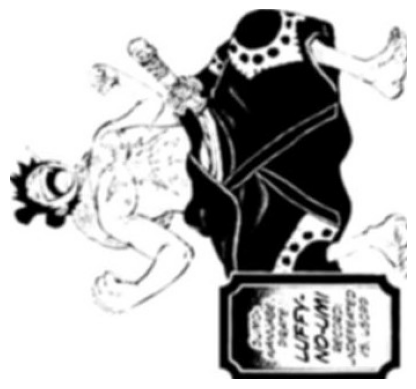

Classe: Luffy
Predição:
Luffy: 0.8648
Kurohige: 0.1183
Law: 0.0061


In [37]:
# Testa o modelo
classe = 'Luffy'
pasta = f'./data_reorganized/teste/{classe}/'
imagem = os.path.join(pasta, os.listdir(pasta)[30])

resposta = predicao_one_piece(modelo_final, imagem)
#mostra a imagem com os tres maiores valores de probabilidade
img = Image.open(imagem)
plt.imshow(img)
plt.axis('off')
plt.show()

print(f"Classe: {classe}")
print("Predição:")
top_3 = sorted(resposta.items(), key=lambda x: x[1], reverse=True)[:3]
for classe, prob in top_3:
    print(f"{classe}: {prob:.4f}")


# Conclusões


Buscamos por um banco de dados que fosse interessante e encontramos um dataset de um anime que gostamos, então decidimos utilizá-lo para construir um classificador de personagens. Nosso objetivo era identificar os personagens do anime a partir de suas imagens, considerando as características visuais predominantes, como cores de pele, roupas e outros elementos marcantes.  

### Limpeza do Dataset
Inicialmente, trabalhamos com o dataset na forma original, mas logo percebemos que o erro de predição se mantinha alto. Iidentificamos que as cores das imagens eram um fator crucial para distinguir os personagens. Muitos personagens possuem cores predominantes específicas, como nas roupas ou na pele, o que servia como um forte indicativo visual para a classificação. 

Decidimos, então, excluir todas as imagens que estavam em negativo, o que melhorou significativamente os resultados.

### Escolha da Arquitetura

Realizamos testes com três arquiteturas populares:

- **VGG**
- **AlexNet**
- **MobileNetV2**

Esses testes foram realizados inicialmente com 20 épocas e imagens redimensionadas para 100x100 pixels. A **MobileNetV2** apresentou o melhor desempenho em termos de acurácia e eficiência computacional, o que foi um critério decisivo para sua escolha, visto que precisávamos de uma arquitetura leve e rápida para executar as predições.

### Ajuste do Treinamento

Com a arquitetura definida, ajustamos o treinamento do modelo. Passamos a utilizar 100 épocas, além de aumentar a resolução das imagens para 256x256 pixels. Como resultado, a acurácia do modelo subiu de **68%** para **87%**.

## Dificuldades Encontradas

- **Imagens em negativo**: As imagens que estavam em negativo confundiram o modelo, levando a altos índices de erro.
- **Limitações computacionais**: O uso de arquiteturas mais pesadas, como a VGG, tornou o trenamento muito lento, o que não tinhamos como contonar.

## Lições Aprendidas

- A **limpeza e pré-processamento dos dados** são etapas fundamentais para garantir a qualidade do modelo. Imagens em negativo podem ou não ajudar na classificação, dependendo do problema.
- A **escolha da arquitetura** deve considerar não apenas a acurácia, mas também a eficiência computacional.
- **Imagens de maior resolução** fornecem mais informações relevantes, mas é importante balancear a resolução com o tempo de processamento.

## Resultados
O melhor modelo apresentou os seguintes resultados:
- Acurácia inicial com imagens 100x100 e 20 épocas: **68%**
- Acurácia final com imagens 256x256 e 100 épocas: **87%**

O modelo final baseado na **MobileNetV2** mostrou-se eficiente, atingindo uma acurácia elevada após os ajustes.